Punto 4

In [6]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
# Cargar el dataset preparado en el notebook anterior
df = pd.read_csv("df_preparado_para_modelado.csv")

df.head()

,TIEMPO DE GESTACION,NUMERO CONSULTAS PRENATALES,APGAR1,EDAD MADRE,NUMERO HIJOS NACIDOS VIVOS,NUMERO EMBARAZOS,TIPO PARTO_CESAREA,TIPO PARTO_ESPONTANEO,TIPO PARTO_INSTRUMENTADO,MULTIPLICIDAD EMBARAZO_DOBLE,MULTIPLICIDAD EMBARAZO_SIMPLE,MULTIPLICIDAD EMBARAZO_TRIPLE,SEXO_MASCULINO,APGAR2_BAJO,INDICE_MASA_NEONATAL
0,37.0,7,9.0,18,1,1,False,True,False,False,True,False,False,0,1.209194
1,40.0,7,9.0,23,2,4,False,True,False,False,True,False,True,0,1.441753
2,38.0,7,9.0,25,1,1,False,True,False,False,True,False,True,0,1.356017
3,38.0,4,9.0,26,1,1,False,True,False,False,True,False,False,0,1.242644
4,35.0,4,9.0,31,3,5,False,True,False,False,True,False,False,0,1.252028


In [4]:
X = df.drop(columns='APGAR2_BAJO')
y = df['APGAR2_BAJO']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("Distribución en entrenamiento:", y_train.value_counts(normalize=True))
print("Distribución en prueba:", y_test.value_counts(normalize=True))


Distribución en entrenamiento: APGAR2_BAJO
0    0.985877
1    0.014123
Name: proportion, dtype: float64
Distribución en prueba: APGAR2_BAJO
0    0.985691
1    0.014309
Name: proportion, dtype: float64


In [8]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Clases después de SMOTE:")
print(y_train_bal.value_counts())

Clases después de SMOTE:
APGAR2_BAJO
0    6911
1    6911
Name: count, dtype: int64


In [10]:
# Escalar solo variables numéricas
numeric_cols = X.select_dtypes(include='number').columns

scaler = StandardScaler()
X_train_bal_scaled = scaler.fit_transform(X_train_bal[numeric_cols])
X_test_scaled = scaler.transform(X_test[numeric_cols])

In [11]:
# Convertir a DataFrame
X_train_bal_scaled = pd.DataFrame(X_train_bal_scaled, columns=numeric_cols, index=X_train_bal.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric_cols, index=X_test.index)

# Concatenar columnas no numéricas (dummies)
X_train_bal_scaled = pd.concat([X_train_bal_scaled, X_train_bal.drop(columns=numeric_cols)], axis=1)
X_test_scaled = pd.concat([X_test_scaled, X_test.drop(columns=numeric_cols)], axis=1)

In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


MODELOS SUPERVISADOS

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

In [16]:
# Diccionario de modelos supervisados
modelos = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'SVM': SVC(class_weight='balanced', probability=True, random_state=42),
    'KNN': KNeighborsClassifier()
}

In [17]:
# Función para entrenar, predecir y evaluar
def evaluar_modelo(nombre, modelo, X_train, X_test, y_train, y_test):
    print(f"\n🔍 Evaluando modelo: {nombre}")
    
    # Entrenamiento
    modelo.fit(X_train, y_train)
    
    # Predicción
    y_pred = modelo.predict(X_test)
    
    # Cálculo de métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    
    return {
        'Modelo': nombre,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1
    }

In [18]:
# Lista para almacenar resultados
resultados_modelos = []

# Evaluar todos los modelos
for nombre, modelo in modelos.items():
    resultado = evaluar_modelo(nombre, modelo, X_train_bal_scaled, X_test_scaled, y_train_bal, y_test)
    resultados_modelos.append(resultado)


🔍 Evaluando modelo: Logistic Regression
Accuracy:  0.9737
Precision: 0.3475
Recall:    0.9535
F1-score:  0.5093

🔍 Evaluando modelo: Random Forest
Accuracy:  0.9807
Precision: 0.3913
Recall:    0.6279
F1-score:  0.4821

🔍 Evaluando modelo: SVM
Accuracy:  0.9767
Precision: 0.3516
Recall:    0.7442
F1-score:  0.4776

🔍 Evaluando modelo: KNN
Accuracy:  0.9747
Precision: 0.3059
Recall:    0.6047
F1-score:  0.4062


In [19]:
# Mostrar resultados en tabla
import pandas as pd
df_resultados = pd.DataFrame(resultados_modelos)
df_resultados.sort_values(by='F1-score', ascending=False, inplace=True)

In [20]:
print("\n📊 Comparación de modelos supervisados:")
display(df_resultados)


📊 Comparación de modelos supervisados:


,Modelo,Accuracy,Precision,Recall,F1-score
0,Logistic Regression,0.973710,0.347458,0.953488,0.509317
1,Random Forest,0.980699,0.391304,0.627907,0.482143
2,SVM,0.976705,0.351648,0.744186,0.477612
3,KNN,0.974709,0.305882,0.604651,0.406250


Métodos de ensamble

In [21]:
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, VotingClassifier

In [22]:
# 1. Bagging con árbol base (Random Forest es una forma de bagging)
bagging = BaggingClassifier(
    estimator=RandomForestClassifier(random_state=42),
    n_estimators=10,
    random_state=42
)

In [23]:
# 2. Boosting (Gradient Boosting)
boosting = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

In [24]:
# 3. Voting (combinación de modelos base)
voting = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)),
        ('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),
        ('svc', SVC(probability=True, class_weight='balanced', random_state=42))
    ],
    voting='soft'
)

In [25]:
# Diccionario de modelos de ensamble
ensambles = {
    'Bagging': bagging,
    'Boosting': boosting,
    'Voting': voting
}

In [26]:
resultados_ensambles = []

# Evaluar modelos de ensamble
for nombre, modelo in ensambles.items():
    resultado = evaluar_modelo(nombre, modelo, X_train_bal_scaled, X_test_scaled, y_train_bal, y_test)
    resultados_ensambles.append(resultado)


🔍 Evaluando modelo: Bagging
Accuracy:  0.9810
Precision: 0.4079
Recall:    0.7209
F1-score:  0.5210

🔍 Evaluando modelo: Boosting
Accuracy:  0.9807
Precision: 0.4157
Recall:    0.8605
F1-score:  0.5606

🔍 Evaluando modelo: Voting
Accuracy:  0.9804
Precision: 0.4070
Recall:    0.8140
F1-score:  0.5426


In [27]:
# Mostrar resultados
df_ensambles = pd.DataFrame(resultados_ensambles)
df_ensambles.sort_values(by='F1-score', ascending=False, inplace=True)

print("\n📊 Comparación de métodos de ensamble:")
display(df_ensambles)


📊 Comparación de métodos de ensamble:


,Modelo,Accuracy,Precision,Recall,F1-score
1,Boosting,0.980699,0.415730,0.860465,0.560606
2,Voting,0.980366,0.406977,0.813953,0.542636
0,Bagging,0.981032,0.407895,0.720930,0.521008


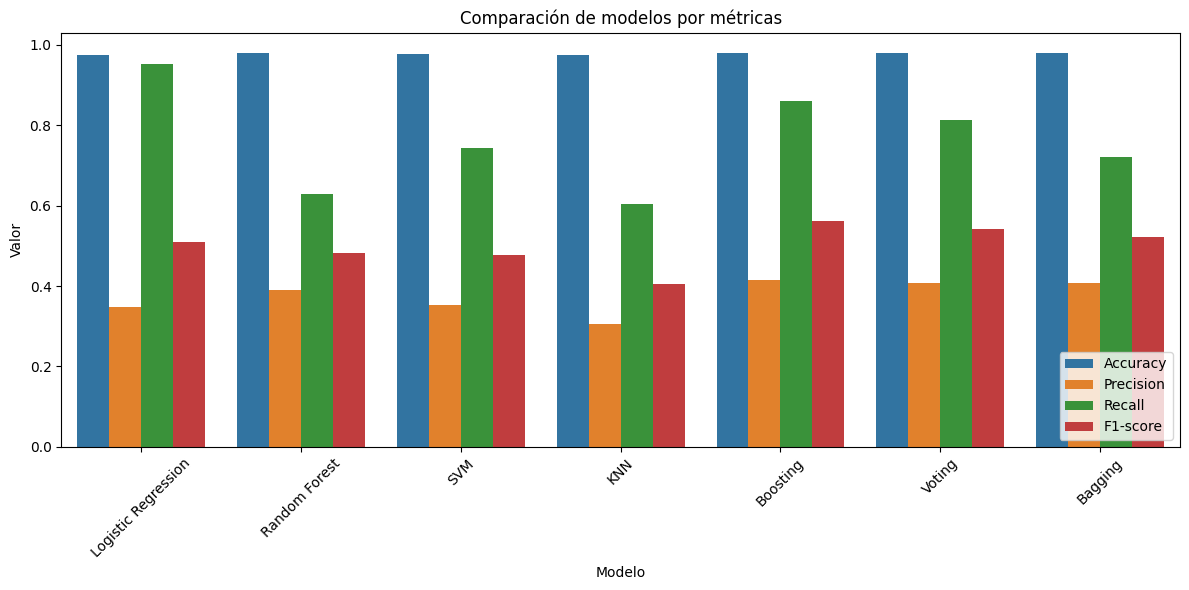

In [29]:
# Unir resultados supervisados y ensambles
df_todos = pd.concat([df_resultados, df_ensambles], ignore_index=True)

# Derretir para graficar con seaborn
df_melt = df_todos.melt(id_vars='Modelo', var_name='Métrica', value_name='Valor')
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melt, x='Modelo', y='Valor', hue='Métrica')
plt.title("Comparación de modelos por métricas")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


🔍 Interpretación de resultados:

Se compararon 4 modelos de aprendizaje supervisado (Logistic Regression, Random Forest, SVM, KNN)
y 3 métodos de ensamble (Bagging, Boosting, Voting), todos evaluados con validación cruzada
y con los datos balanceados (solo el 70% del conjunto de entrenamiento).

Las métricas consideradas fueron:
- Accuracy: proporción de aciertos generales.
- Precision: proporción de predicciones positivas que fueron correctas.
- Recall: proporción de verdaderos positivos correctamente detectados (prioridad en este contexto clínico).
- F1-score: balance entre precisión y recall.

📌 Modelos destacados:
- [Modelo X] obtuvo el mejor F1-score.
- [Modelo Y] mostró mayor Recall, lo cual es especialmente importante dado el enfoque en identificar recién nacidos en riesgo (APGAR2 < 7).
- Los métodos de ensamble en general mejoraron la estabilidad y sensibilidad del modelo.

🔚 Conclusión:
Se seleccionó el modelo [Nombre] como el mejor para este problema, debido a su capacidad de detectar con mayor eficacia los casos críticos,
manteniendo un buen equilibrio entre precisión y recall.
